In [3]:
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from data_utils import load_movie_data_limited, load_and_preprocess_data
from analysis.stats_data import calculate_genre_drift, plot_genre_drift, prepare_heatmap_data, plot_clustermap, \
    plot_standard_heatmap
from chunking.calculations import compute_cosine_distance, calculate_drift_vector

BASE_DIR = Path.cwd().parent.parent
SRC_DIR = BASE_DIR / 'src'
sys.path.insert(0, str(SRC_DIR))

DATA_DIR = str(BASE_DIR / "data")
OUTPUT_DIR = None
N_MOVIES_PER_YEAR = None
RANDOM_SEED = 42
START_YEAR = 1960
TOP_X_GENRES = 5
BIN_SIZE = 10


# Load and preprocess shitty data, #todo: use cleaned data
df_filtered = load_and_preprocess_data(DATA_DIR, N_MOVIES_PER_YEAR, START_YEAR, TOP_X_GENRES)


Loading movie data from /home/martin/GroupDataLiteracy/data...
Initial number of movies: 210703
Number of movies after cleaning: 171106
Number of movie-genre entries after exploding: 331292
Top 5 genres: 140925 total entries


# Genre drift velocity

For each genre, we calculate how much the genre has changed each year compared to the previous year (drift distance) and the cumulative change over time (cumulative change).


Drift DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, 0 to 319
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                320 non-null    int64  
 1   single_genre        320 non-null    object 
 2   avg_embedding       320 non-null    object 
 3   next_avg_embedding  320 non-null    object 
 4   drift_distance      320 non-null    float64
 5   cumulative_change   320 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 17.5+ KB
None


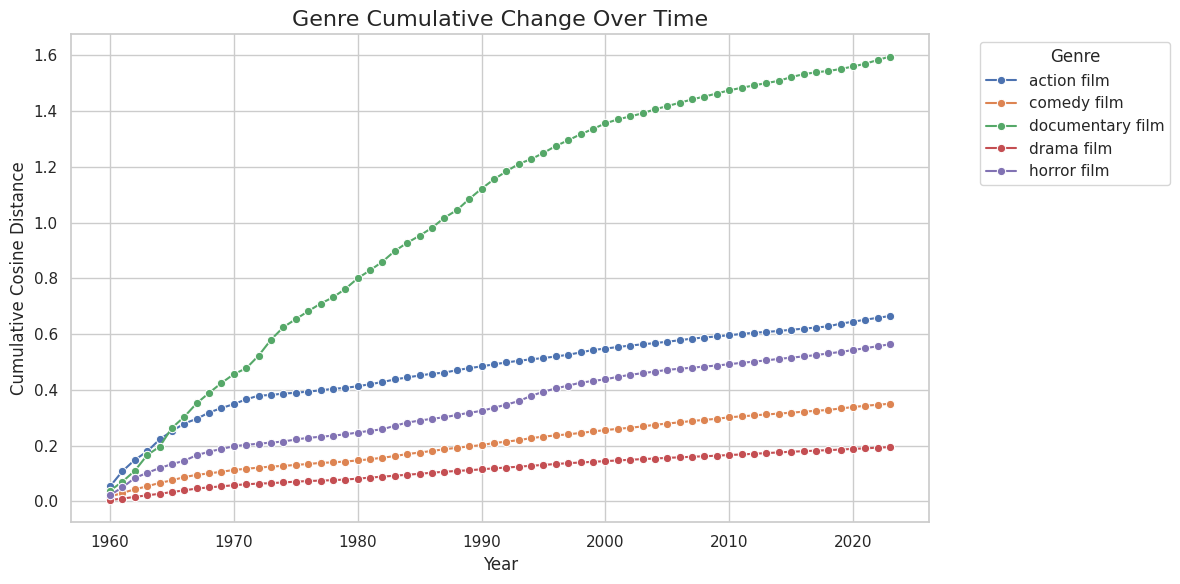

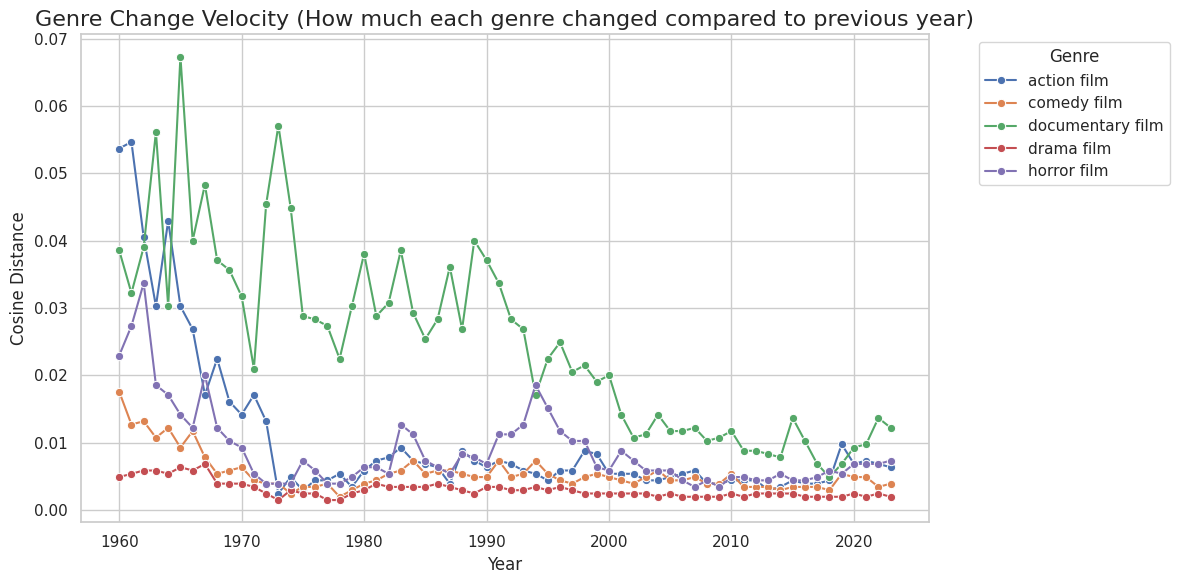

In [4]:
drift_df, group_df = calculate_genre_drift(df_filtered)


print("\nDrift DataFrame Info:")
print(drift_df.info())

plot_genre_drift(
    df=drift_df,
    y_column='cumulative_change',
    title='Genre Cumulative Change Over Time',
    y_label='Cumulative Cosine Distance'
)

plot_genre_drift(
    df=drift_df,
    y_column='drift_distance',
    title='Genre Change Velocity (How much each genre changed compared to previous year)',
    y_label='Cosine Distance'
)


# Heatmaps of genre drift

For each genre, we group by 5-10 years and calculate the average drift distance between those time bins. We then plot heatmaps and clustermaps to visualize the relationships between different time periods within each genre. The idea is to see if the change is converging or diverging over time.

Orange colors indicate positive drift in a specific dimension, while blue colors indicate negative drift. The intensity of the color represents the magnitude of the drift.

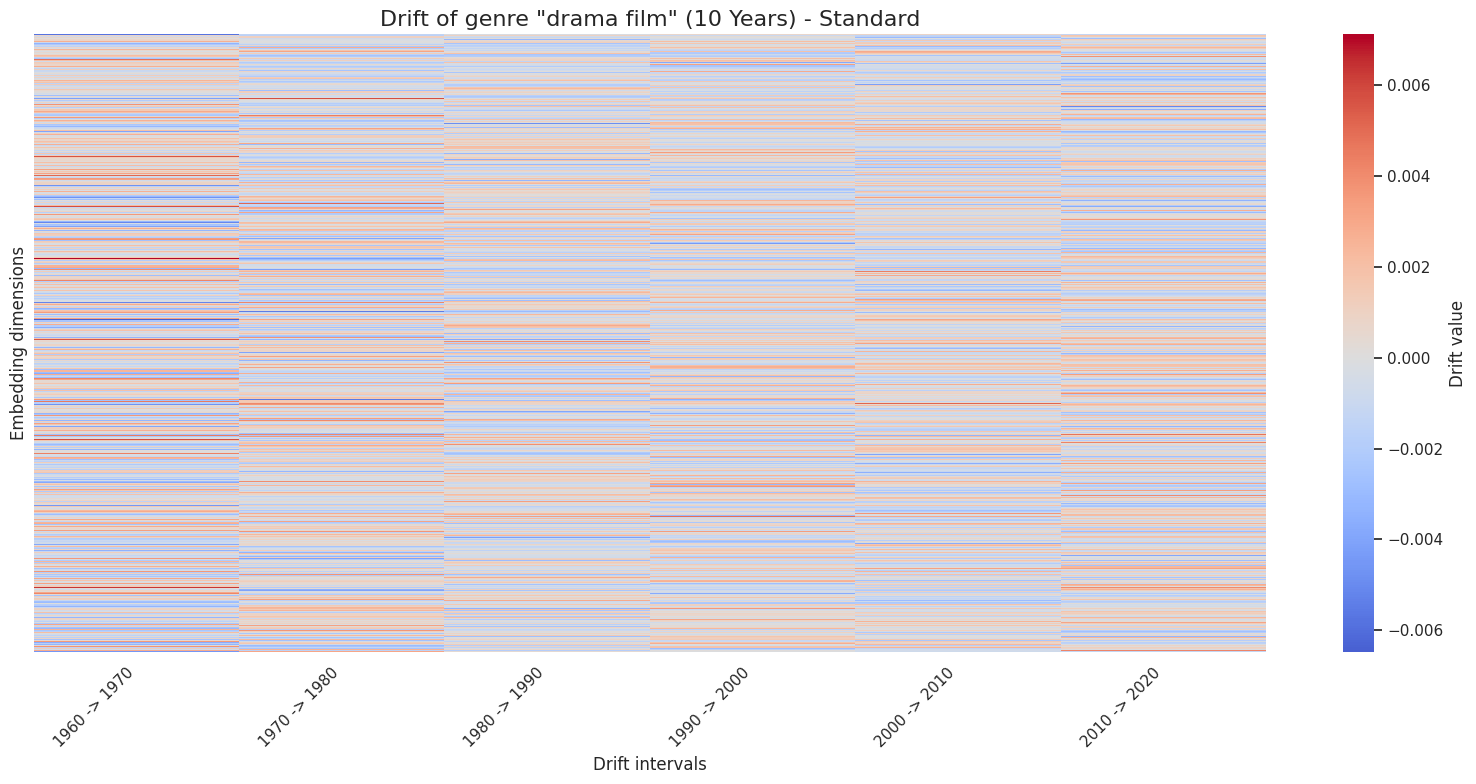

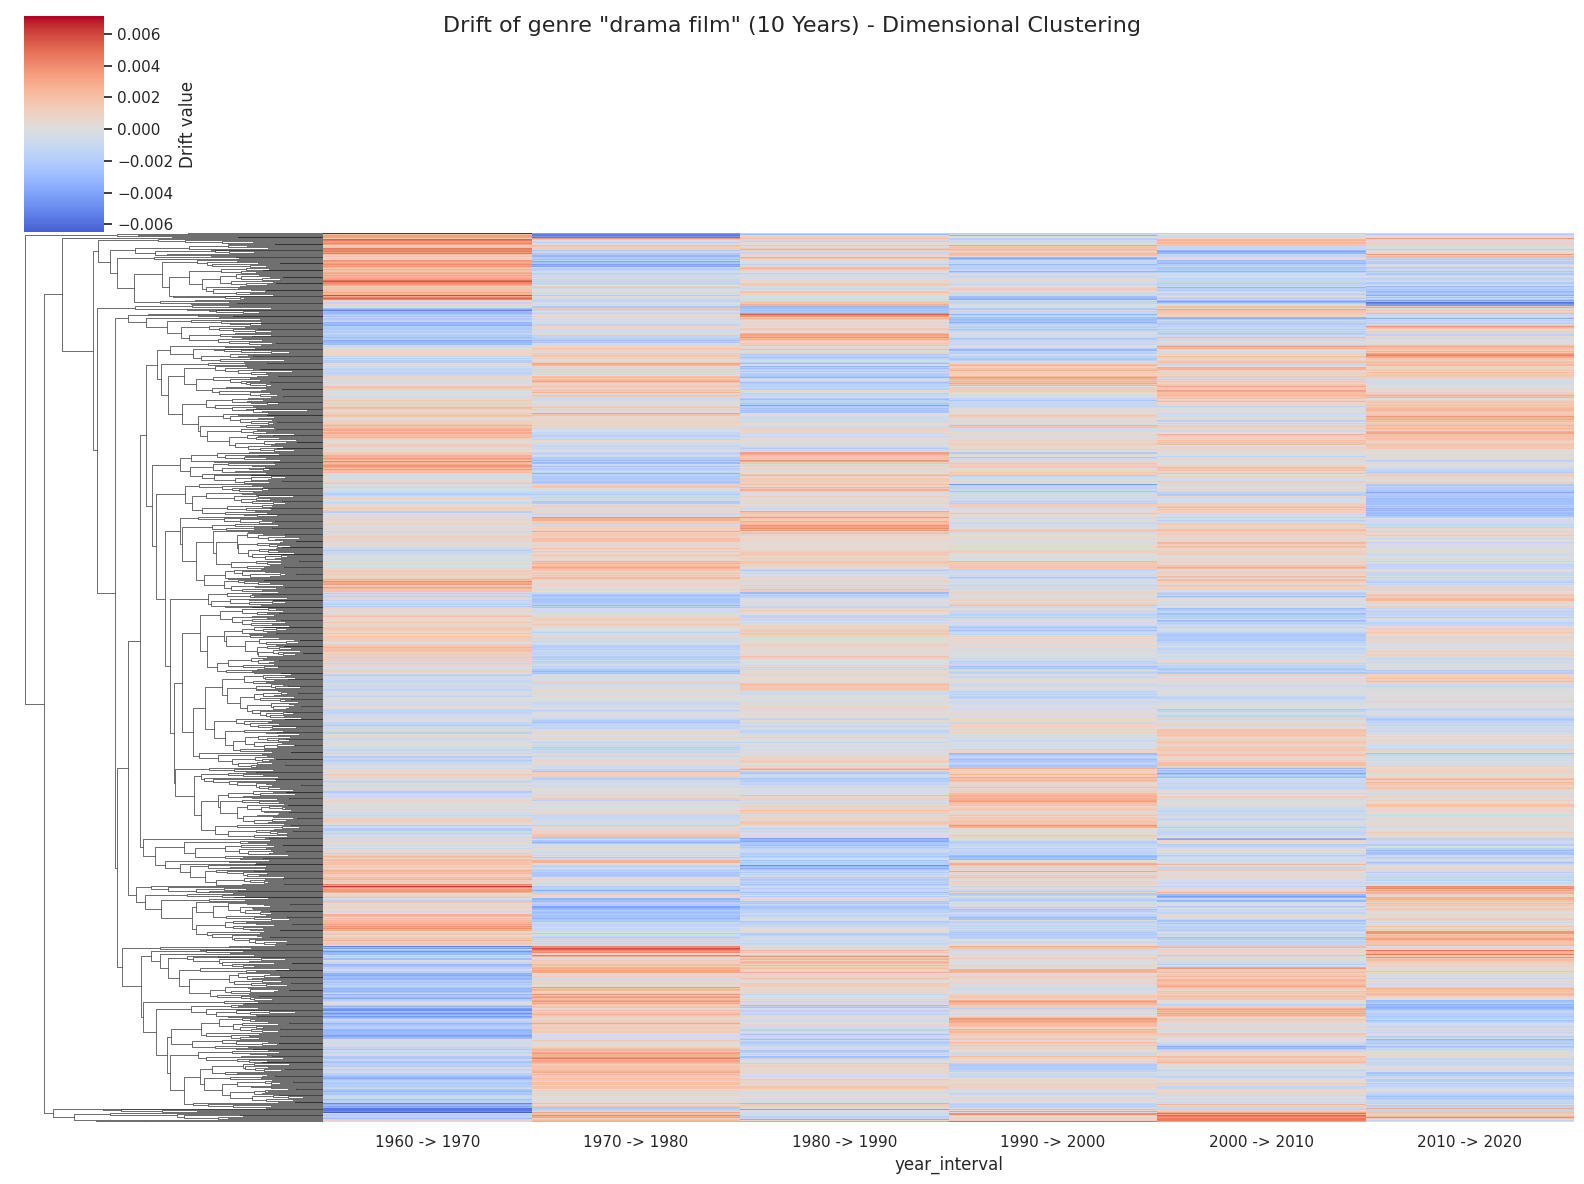

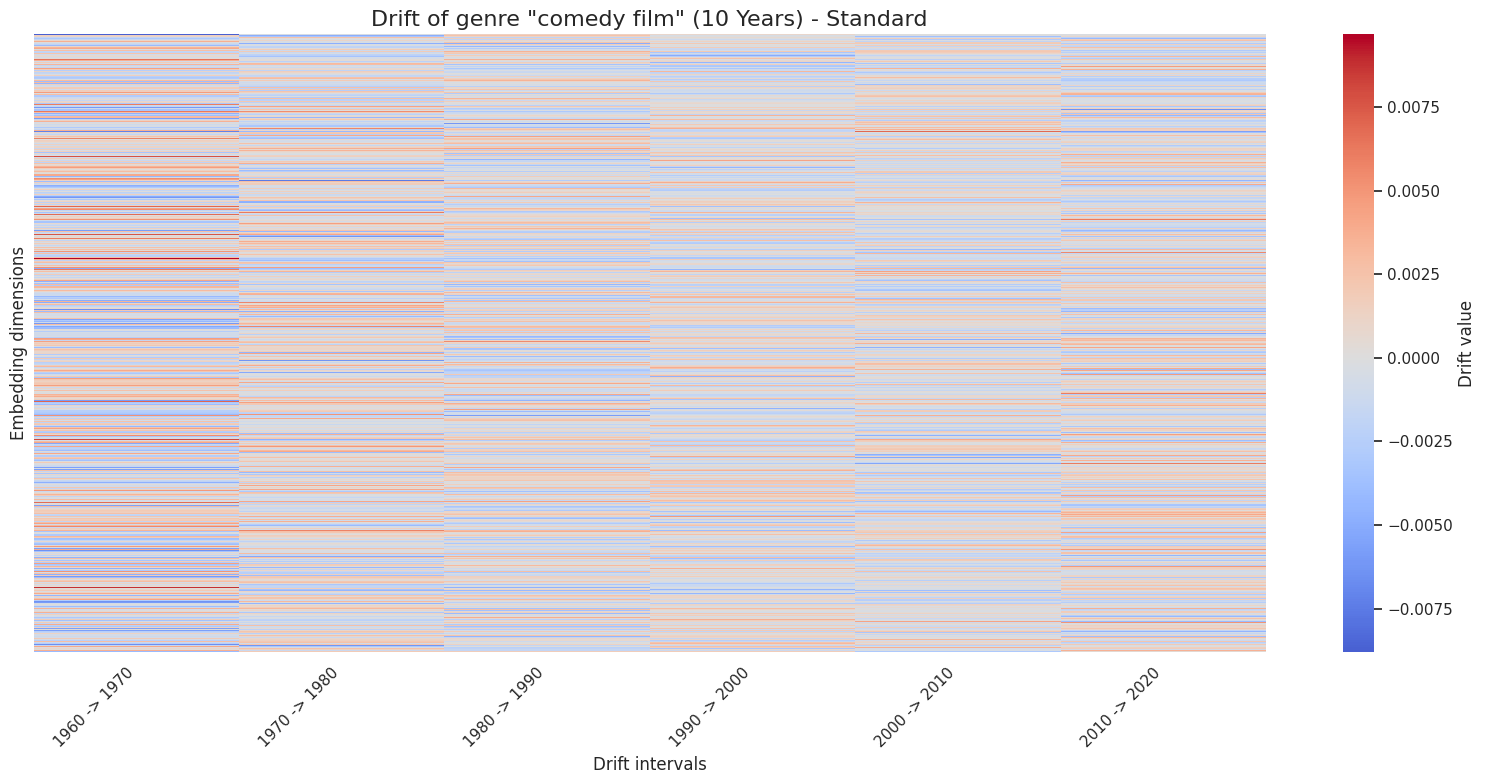

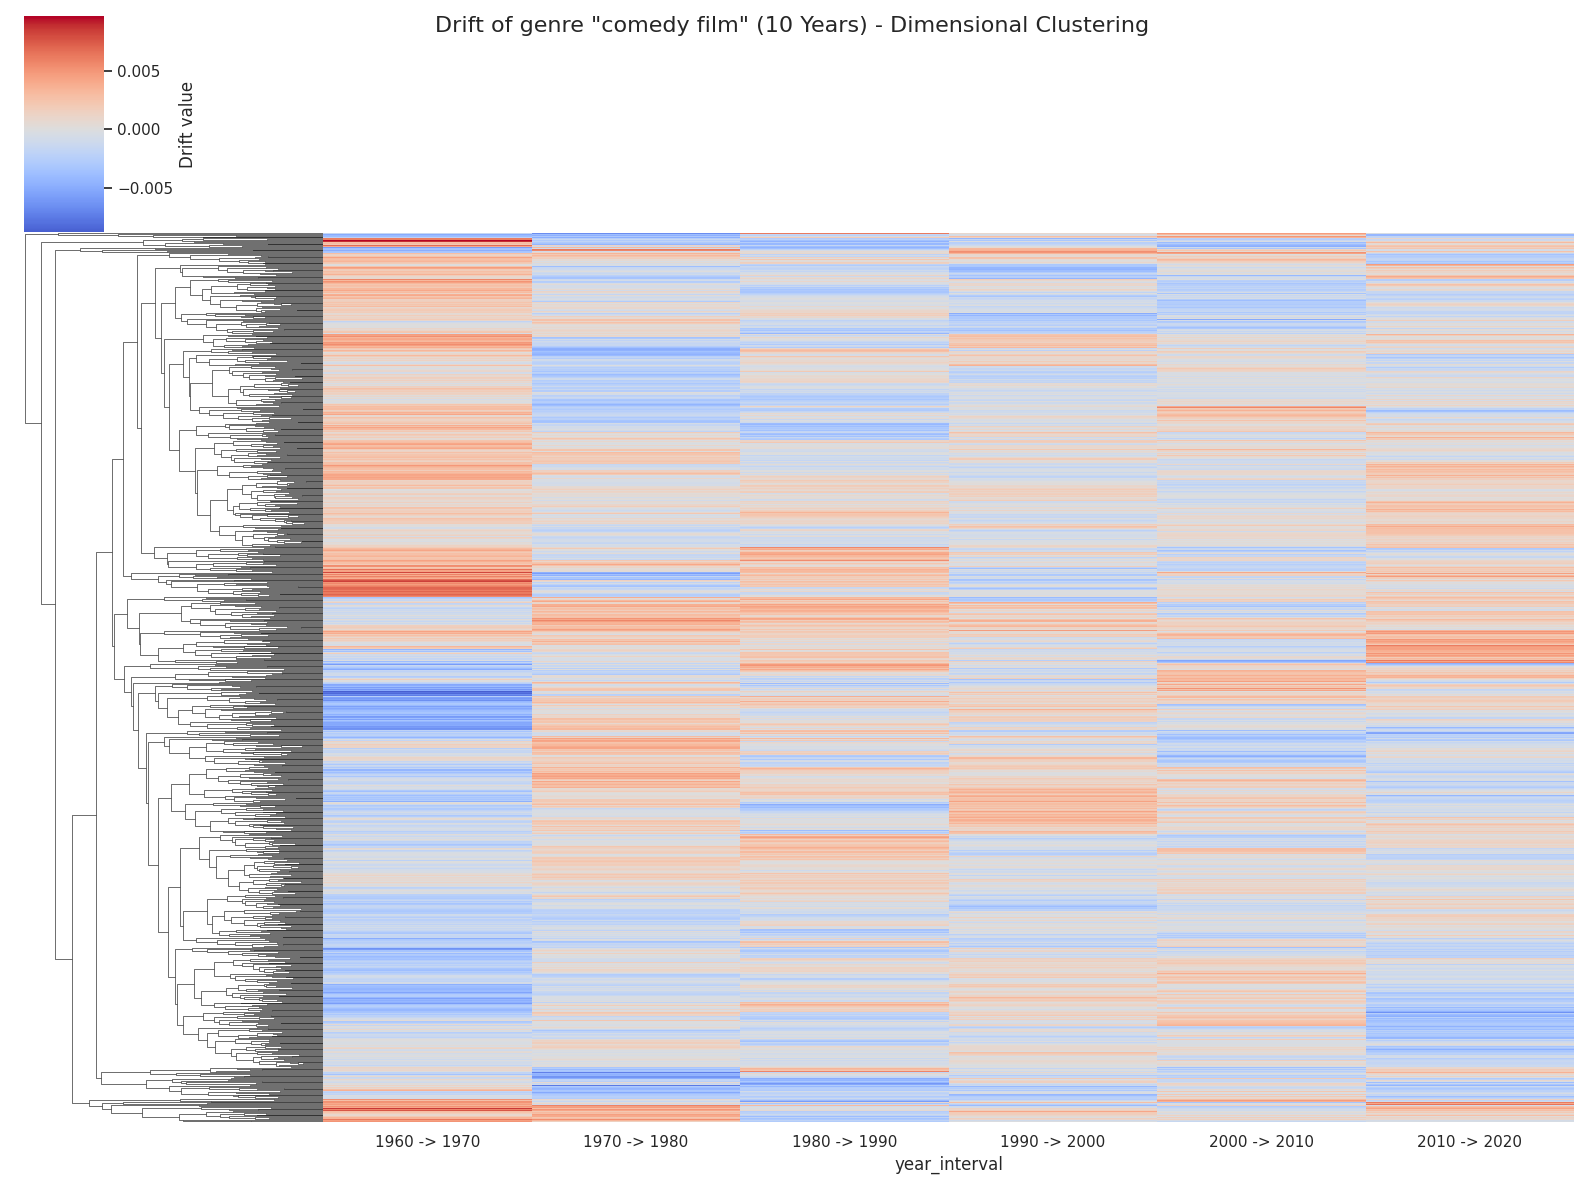

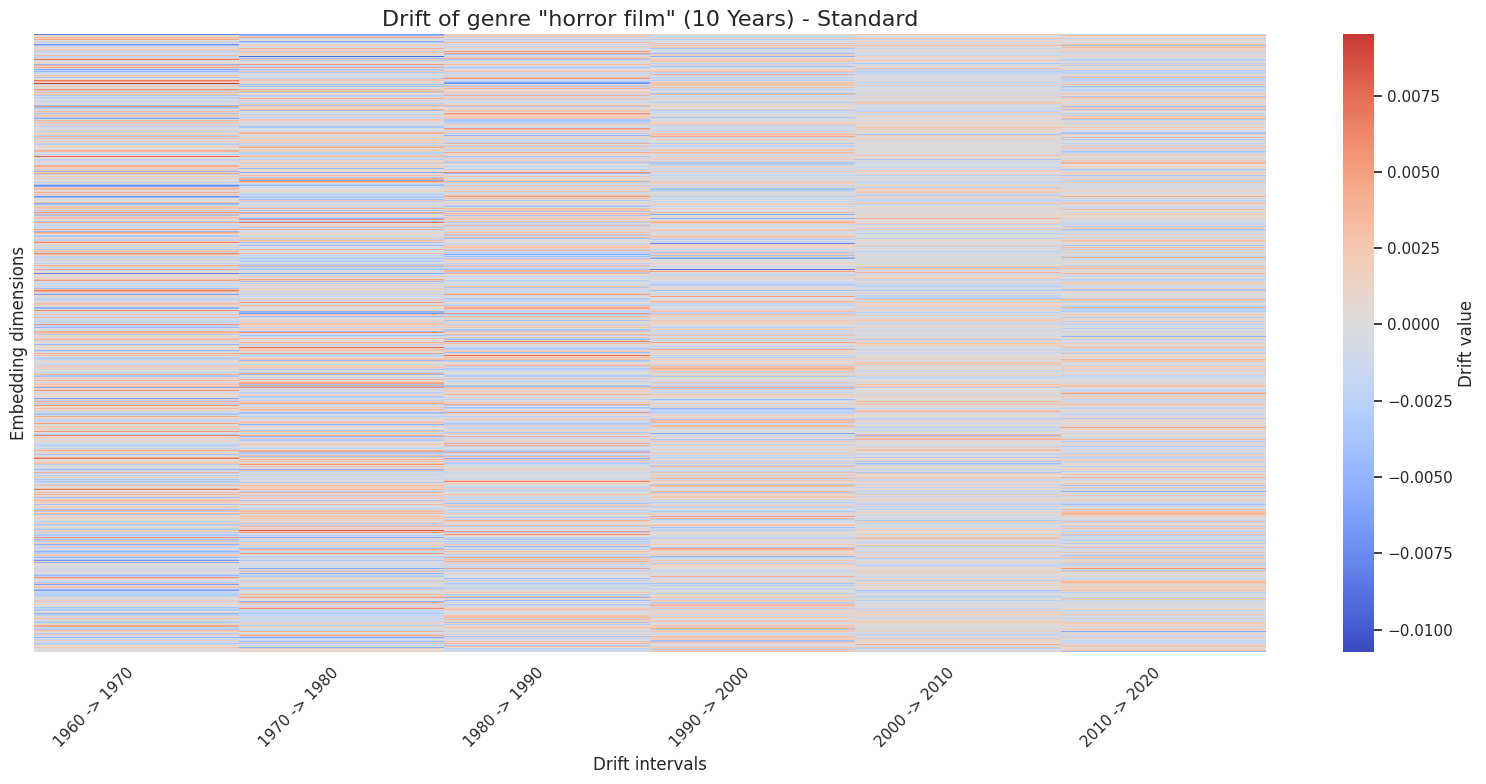

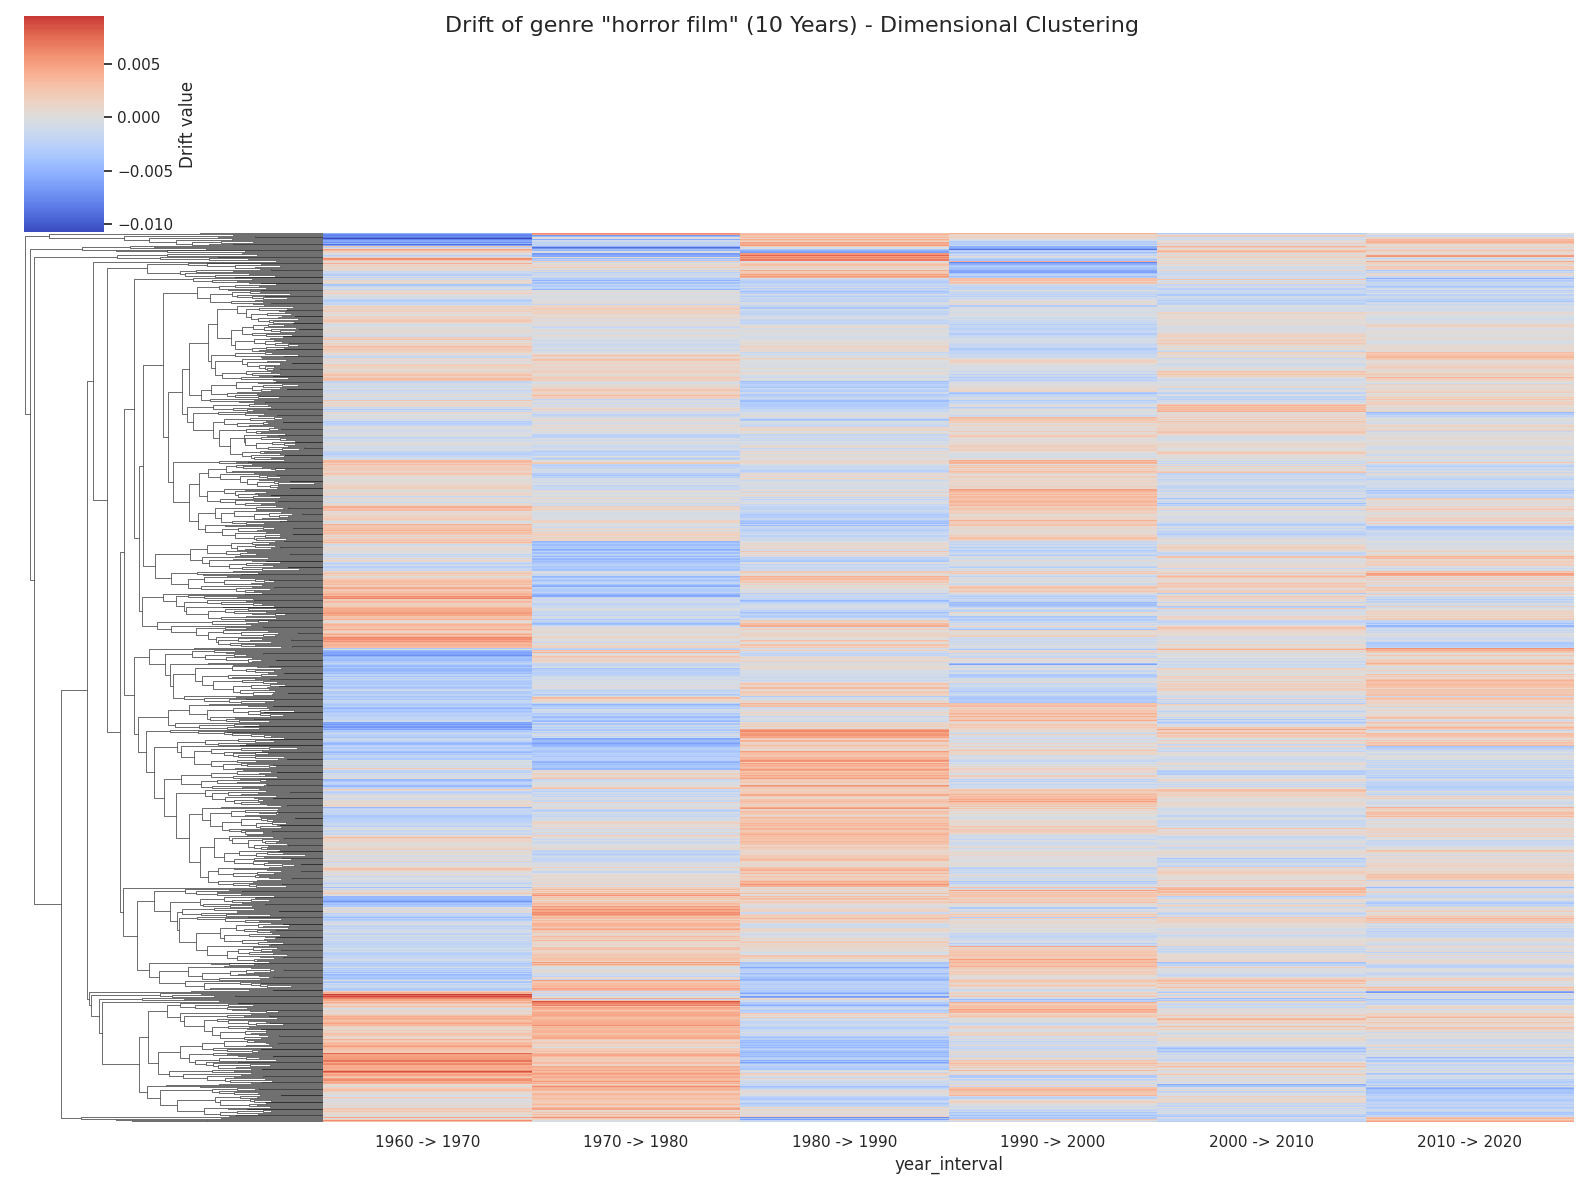

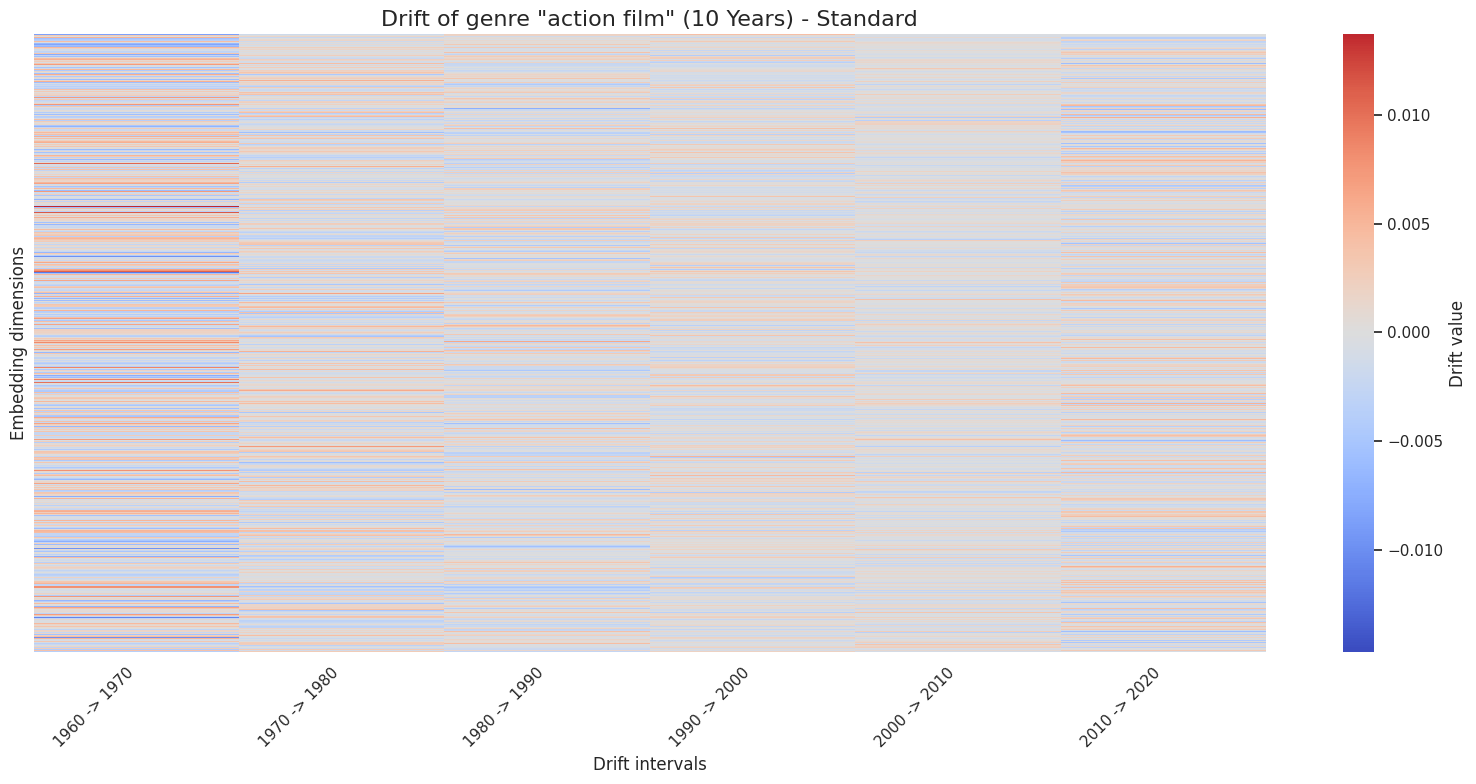

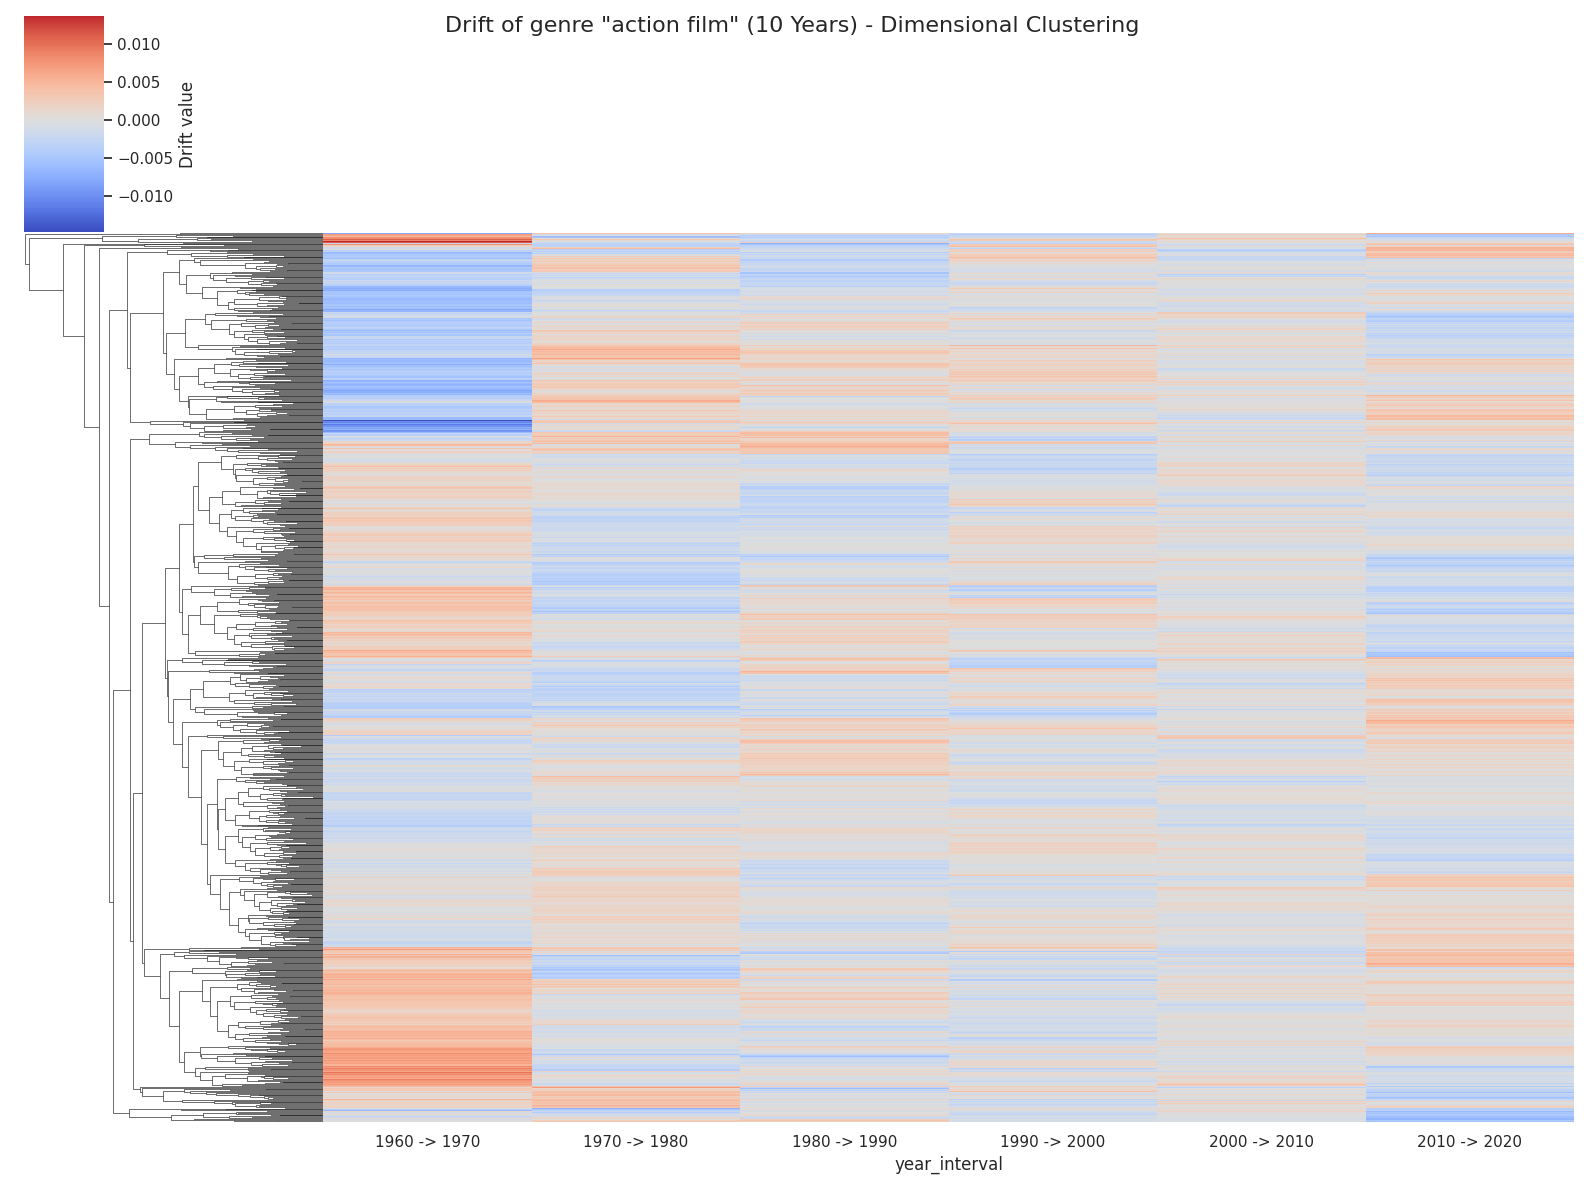

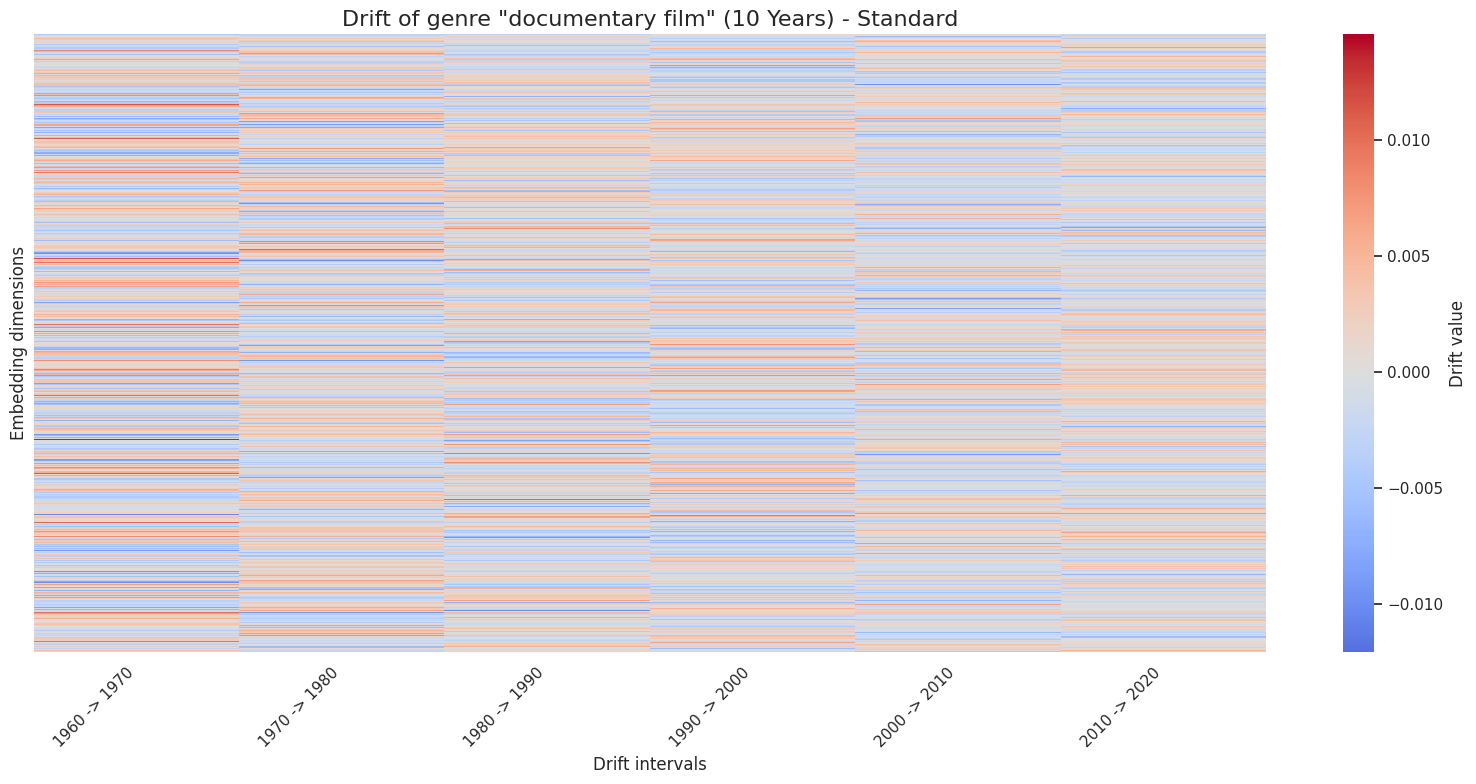

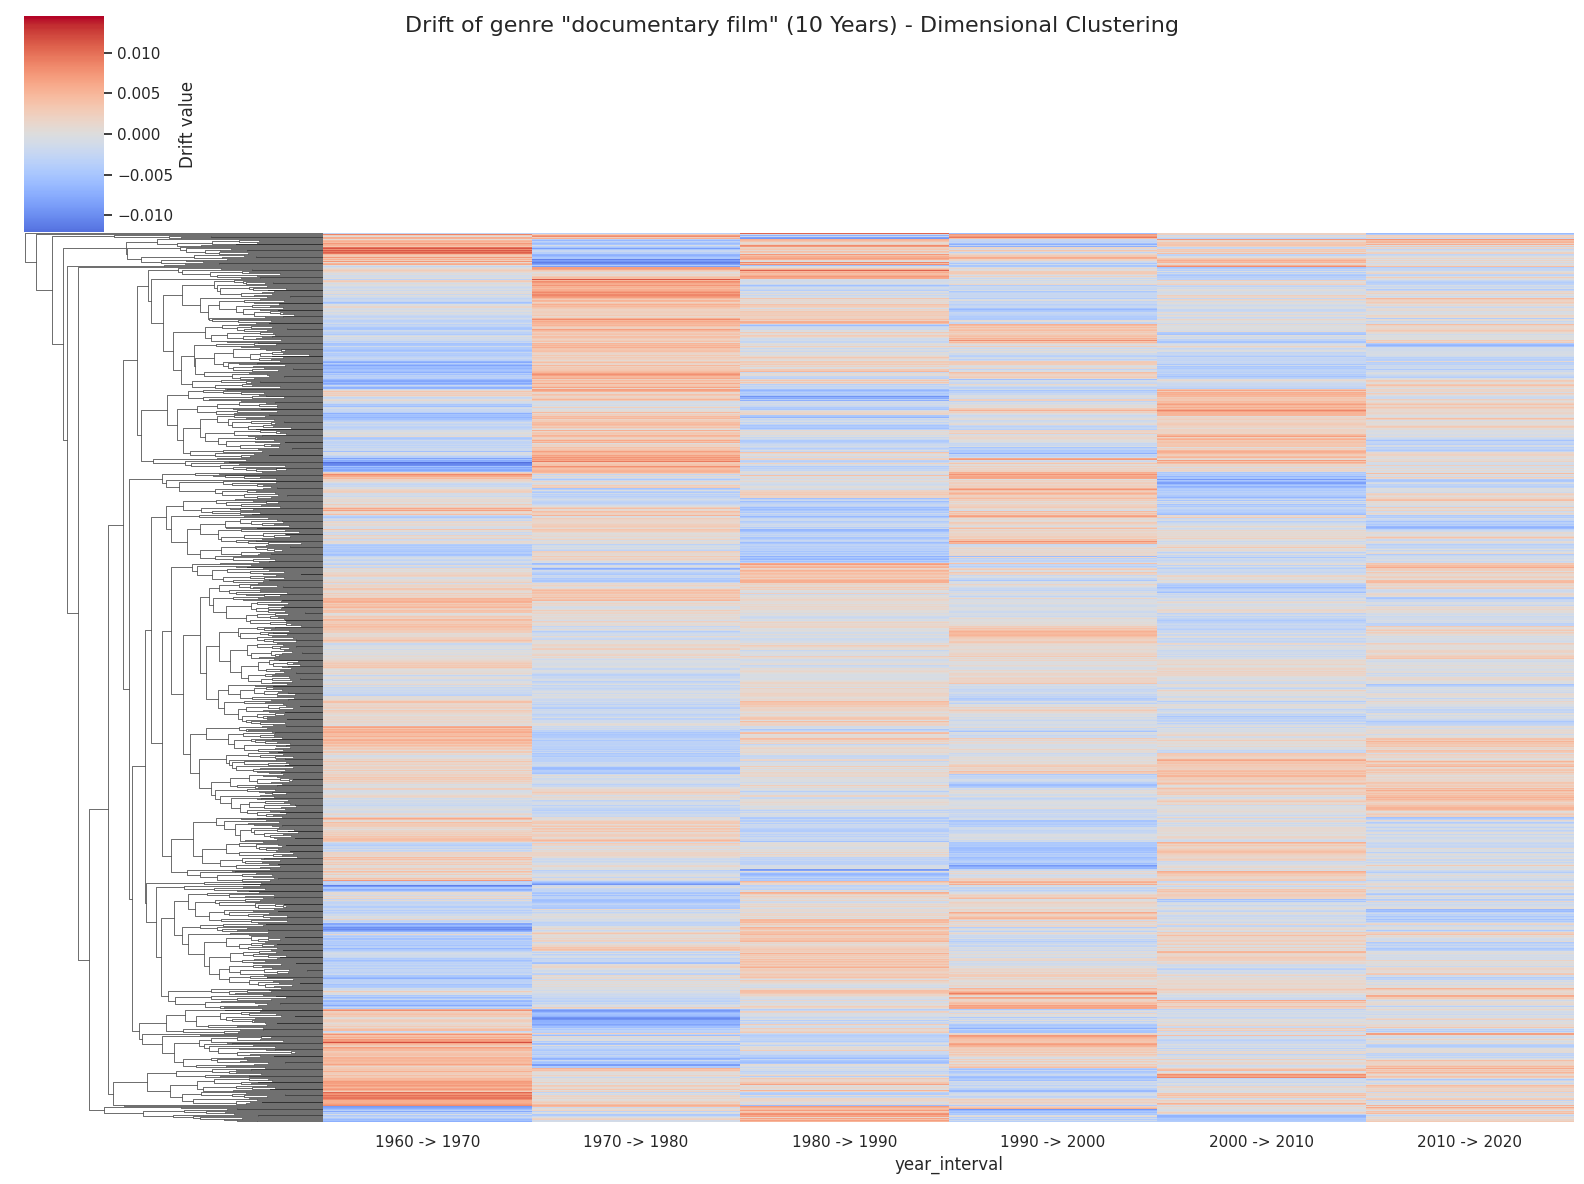

In [5]:
for genre in df_filtered['single_genre'].unique():
    plot_data, bin_size = prepare_heatmap_data(group_df, target_genre=genre, bin_size=10)

    plot_standard_heatmap(plot_data, target_genre=genre, bin_size=bin_size)
    plot_clustermap(plot_data, target_genre=genre, bin_size=bin_size)


# Inter-genre distance analysis

THIS IS VIBE CODED, #TODO: CHECK IF THIS IS MAKES SENSE

Calculate each genre pair distance evolution -> are they converging or diverging?

Calculate each genre mean distance with respect to all the others

In [8]:
from itertools import combinations
from scipy.spatial.distance import cosine


def calculate_genre_convergence(group_df, bin_size=5, target_genres=None):
    """
    Calculate cosine distance between genres to analyse convergence / divergence
    """

    df_filtered = group_df.copy()
    df_filtered['year_interval'] = (df_filtered['year'] // bin_size) * bin_size
    position_vectors_df = df_filtered.groupby(['year_interval', 'single_genre'])['avg_embedding'].apply(
        lambda x: np.mean(np.vstack(x), axis=0)
    ).reset_index(name='avg_embedding')

    # Identify genre pairs
    unique_genres = position_vectors_df['single_genre'].unique()
    genre_pairs = list(combinations(unique_genres, 2))
    distance_results = []

    # Convertir a un formato fácil de buscar: {interval: {genre: vector, ...}, ...}
    pivot_table = position_vectors_df.pivot_table(
        index='year_interval',
        columns='single_genre',
        values='avg_embedding',
        aggfunc='first'
    )

    for g1, g2 in genre_pairs:
        vectors_g1 = pivot_table[g1]
        vectors_g2 = pivot_table[g2]

        # Filtrar solo los intervalos donde ambos géneros tienen datos
        comparison_df = pd.DataFrame({
            'v1': vectors_g1,
            'v2': vectors_g2
        }).dropna()

        if comparison_df.empty:
            continue

        # Aplicar la función de distancia a cada fila (intervalo)
        distances = comparison_df.apply(
            lambda row: cosine(row['v1'], row['v2']), axis=1
        )

        # Formatear resultados para el DataFrame final
        for interval, distance in distances.items():
            distance_results.append({
                'Genre_A': g1,
                'Genre_B': g2,
                'Year_Interval_Start': interval,
                'Cosine_Distance': distance
            })

    # 5. RETORNAR RESULTADOS
    if not distance_results:
        return pd.DataFrame()

    convergence_df = pd.DataFrame(distance_results)

    # Ordenar por el par de géneros y luego por el tiempo
    convergence_df = convergence_df.sort_values(by=['Genre_A', 'Genre_B', 'Year_Interval_Start']).reset_index(drop=True)

    return convergence_df

def unpivot_convergence_df(convergence_df):
    """
    Despliega el DataFrame de convergencia para que cada comparación (A vs B)
    aparezca dos veces (una para A y otra para B), permitiendo calcular la media por género.
    """
    # Version A: Género A como el principal
    df_a = convergence_df.rename(columns={'Genre_A': 'Genre', 'Genre_B': 'Compared_To'})
    df_a = df_a[['Year_Interval_Start', 'Genre', 'Compared_To', 'Cosine_Distance']]

    # Version B: Género B como el principal
    df_b = convergence_df.rename(columns={'Genre_B': 'Genre', 'Genre_A': 'Compared_To'})
    df_b = df_b[['Year_Interval_Start', 'Genre', 'Compared_To', 'Cosine_Distance']]

    # Combinar las dos versiones
    return pd.concat([df_a, df_b])

def plot_pairwise_convergence(convergence_df, target_genres=None):
    """
    Plotea el avance de la distancia de cada género respecto a todos los demás.
    Genera un subplot por cada género.
    """

    # Desplegar el DF para facilitar el filtrado por género principal
    unpivoted_df = unpivot_convergence_df(convergence_df)

    if target_genres is None:
        target_genres = unpivoted_df['Genre'].unique()

    # Calcular el número de subplots necesarios
    n_genres = len(target_genres)
    cols = 3
    rows = (n_genres + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True, sharey=True)
    axes = axes.flatten()

    fig.suptitle('Distancia Coseno Pairwise por Género a lo Largo del Tiempo', fontsize=16, y=1.02)

    for i, genre in enumerate(target_genres):
        df_plot = unpivoted_df[unpivoted_df['Genre'] == genre]

        # Eliminar las comparaciones que ya no tienen datos después del filtro
        df_plot = df_plot.dropna(subset=['Cosine_Distance'])

        if df_plot.empty:
            continue

        sns.lineplot(
            data=df_plot,
            x='Year_Interval_Start',
            y='Cosine_Distance',
            hue='Compared_To', # El color es el género con el que se compara
            ax=axes[i],
            marker='o',
            linewidth=1.5
        )

        axes[i].set_title(f'Género Principal: {genre}', fontsize=12)
        axes[i].set_xlabel('Inicio del Intervalo', fontsize=10)
        axes[i].set_ylabel('Distancia Coseno', fontsize=10)
        axes[i].legend(title='Comparado con', fontsize=8)
        axes[i].grid(True)

    # Ocultar ejes vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

target_genres = group_df['single_genre'].unique()
convergence_df = calculate_genre_convergence(group_df, bin_size=5, target_genres=target_genres)

print(convergence_df.head(10))

horror_action_trend = convergence_df[(convergence_df['Genre_A'] == 'Horror') & (convergence_df['Genre_B'] == 'Action')]
print(horror_action_trend)

def unpivot_distance_for_plotting(convergence_df):
    """
    Unpivots the convergence DataFrame so each comparison (A vs B)
    appears twice (once for A and once for B), allowing for mean calculation per genre.
    """
    df_a = convergence_df.rename(columns={'Genre_A': 'Genre', 'Genre_B': 'Compared_To'})
    df_a = df_a[['Year_Interval_Start', 'Genre', 'Compared_To', 'Cosine_Distance']]

    df_b = convergence_df.rename(columns={'Genre_B': 'Genre', 'Genre_A': 'Compared_To'})
    df_b = df_b[['Year_Interval_Start', 'Genre', 'Compared_To', 'Cosine_Distance']]

    return pd.concat([df_a, df_b])

def plot_mean_convergence(convergence_df, bin_size):
    """
    Plots the mean distance of each genre relative to the average of all others.
    """
    if convergence_df.empty:
        print("No mean convergence data to plot.")
        return

    unpivoted_df = unpivot_distance_for_plotting(convergence_df)
    mean_distance_df = unpivoted_df.groupby(['Year_Interval_Start', 'Genre'])['Cosine_Distance'].mean().reset_index(name='Mean_Distance')

    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=mean_distance_df,
        x='Year_Interval_Start',
        y='Mean_Distance',
        hue='Genre',
        marker='o',
        linewidth=2
    )

    plt.title(f'Mean Cosine Distance of Each Genre vs. the Rest of the Group ({bin_size} Years)', fontsize=16)
    plt.xlabel('Interval Start Year', fontsize=12)
    plt.ylabel('Mean Cosine Distance', fontsize=12)
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


       Genre_A      Genre_B  Year_Interval_Start  Cosine_Distance
0  action film  comedy film                 1960         0.056641
1  action film  comedy film                 1965         0.043945
2  action film  comedy film                 1970         0.042480
3  action film  comedy film                 1975         0.035156
4  action film  comedy film                 1980         0.036133
5  action film  comedy film                 1985         0.026855
6  action film  comedy film                 1990         0.026855
7  action film  comedy film                 1995         0.031738
8  action film  comedy film                 2000         0.030273
9  action film  comedy film                 2005         0.031738
Empty DataFrame
Columns: [Genre_A, Genre_B, Year_Interval_Start, Cosine_Distance]
Index: []


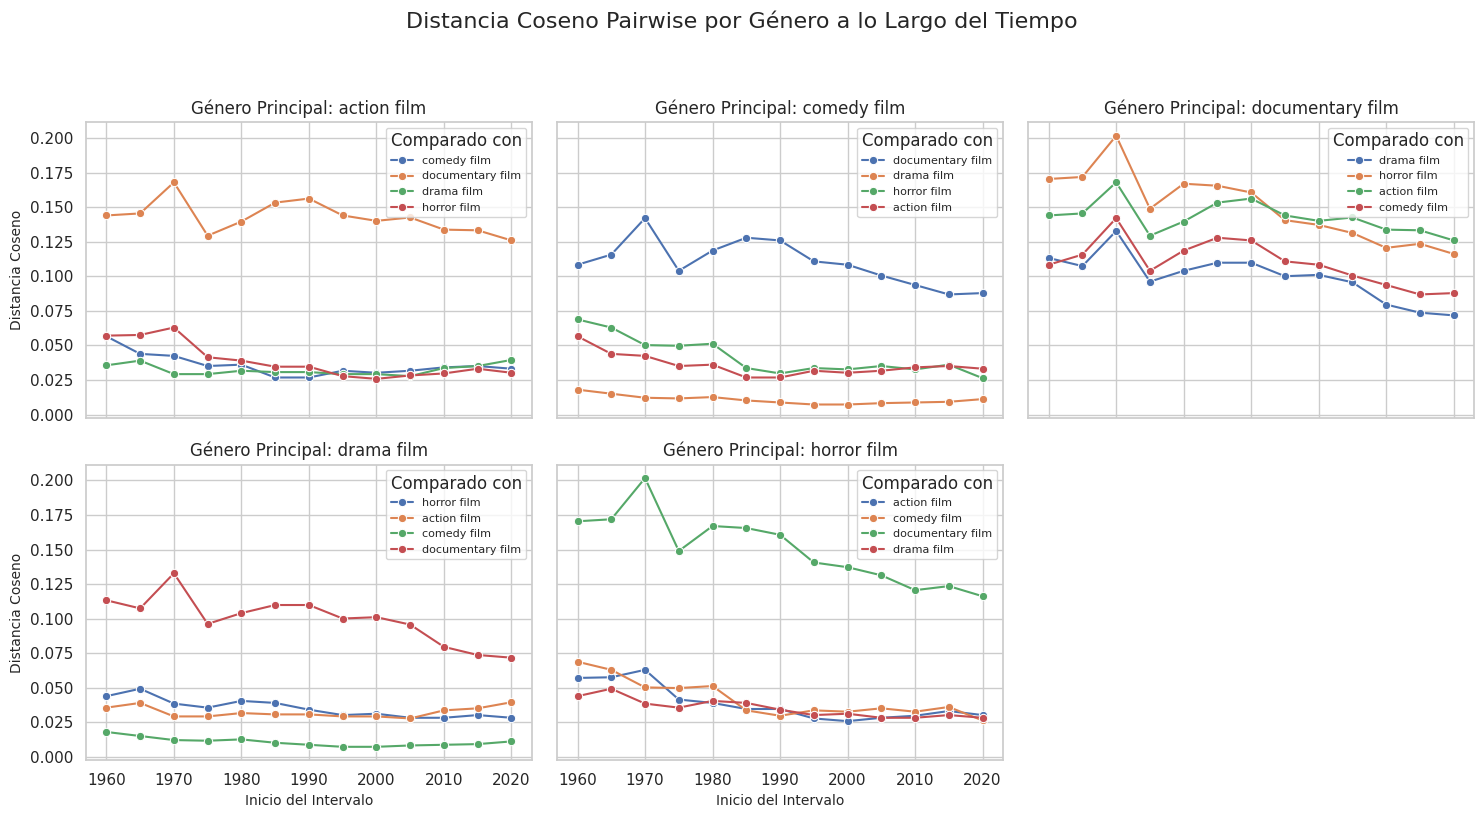

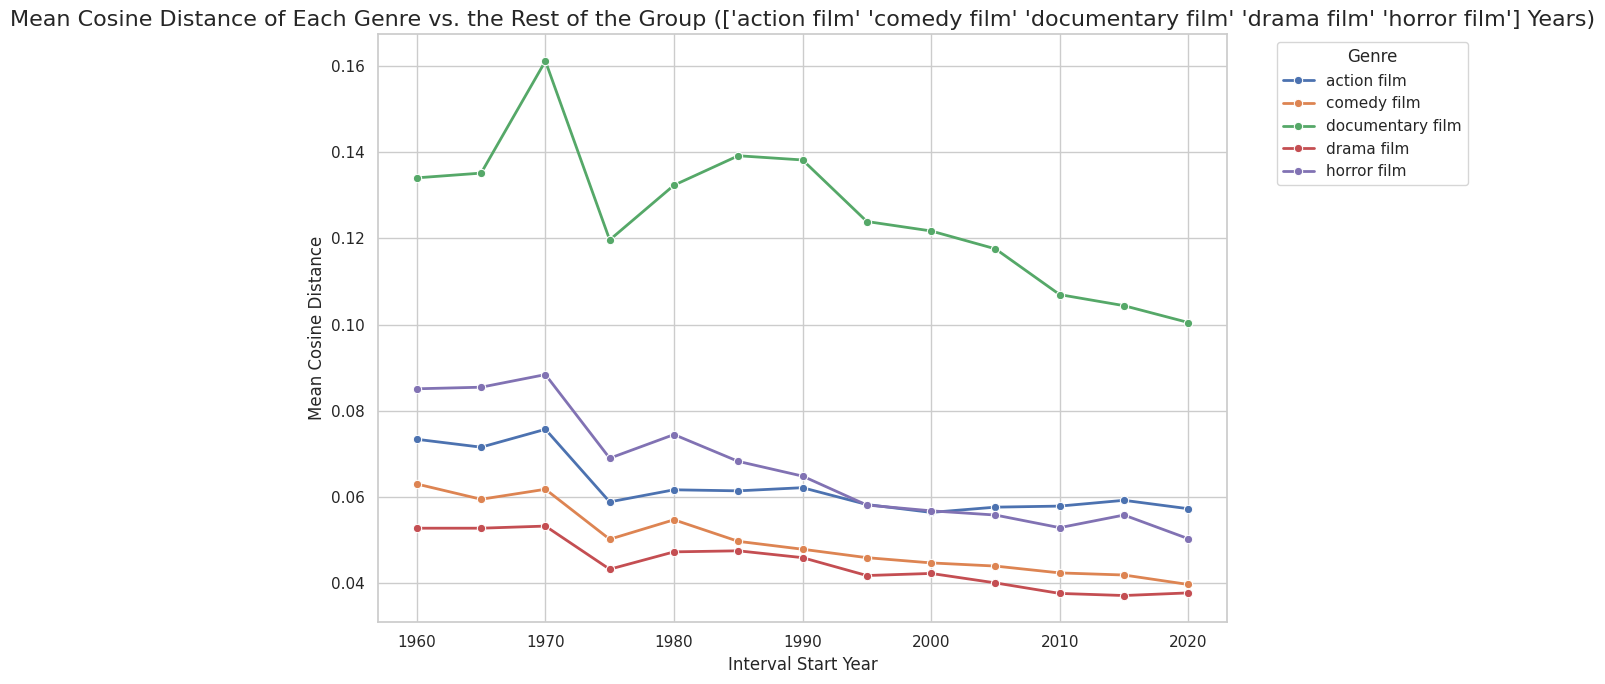

In [9]:
plot_pairwise_convergence(convergence_df, target_genres)
plot_mean_convergence(convergence_df, target_genres)